In [15]:
# ============================================
# STAGE 1 - FEATURE EXTRACTION
# MobileNetV2 for Cocoa Ripeness Classification
# Binary Class: Mentah (0) vs Matang (1)
# ============================================

import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# -----------------------------
# CONFIGURATION
# -----------------------------
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 30
DATASET_PATH = "/content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/Klasifikasi-Kakao/Cocoa Ripeness Dataset"
RANDOM_STATE = 42

# -----------------------------
# LOAD DATASET & LABELING
# -----------------------------
def load_dataset(path):
    images = []
    labels = []

    for file in os.listdir(path):
        if not file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        # Label dari prefix nama file
        if file.startswith("I"):
            label = 0  # Mentah
        elif file.startswith(("M", "S")):
            label = 1  # Matang
        else:
            continue

        img_path = os.path.join(path, file)
        img = tf.keras.preprocessing.image.load_img(
            img_path, target_size=(IMG_SIZE, IMG_SIZE)
        )
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0

        images.append(img)
        labels.append(label)

    return np.array(images), np.array(labels)

print("[INFO] Loading dataset...")
X, y = load_dataset(DATASET_PATH)
print("[INFO] Total samples:", len(y))

# -----------------------------
# TRAIN / VAL / TEST SPLIT
# -----------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=RANDOM_STATE
)

print("[INFO] Train:", len(y_train))
print("[INFO] Validation:", len(y_val))
print("[INFO] Test:", len(y_test))

# -----------------------------
# DATA AUGMENTATION
# -----------------------------
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

# -----------------------------
# CLASS WEIGHT (IMBALANCE HANDLING)
# -----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weight = {
    0: class_weights[0],
    1: class_weights[1]
}

print("[INFO] Class weights:", class_weight)

# -----------------------------
# MODEL ARCHITECTURE
# -----------------------------
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# FREEZE BACKBONE
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

# -----------------------------
# COMPILE MODEL
# -----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

model.summary()

# -----------------------------
# CALLBACKS
# -----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

# -----------------------------
# TRAINING (STAGE 1)
# -----------------------------
print("[INFO] Training Stage 1 (Feature Extraction)...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

# -----------------------------
# EVALUATION (TEST SET)
# -----------------------------
print("[INFO] Evaluating on test set...")
test_results = model.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")

# -----------------------------
# CLASSIFICATION REPORT
# -----------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n[INFO] Classification Report (Threshold = 0.5)")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Mentah", "Matang"]
    )
)

# -----------------------------
# SAVE MODEL (STAGE 1)
# -----------------------------
model.save("mobilenetv2_cocoa_stage1.h5")
print("[INFO] Model saved as mobilenetv2_cocoa_stage1.h5")

# =====================================================
# STAGE 2 - FINE TUNING
# MobileNetV2 Cocoa Ripeness Classification
# =====================================================

import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np

print("[INFO] Starting Stage 2 Fine-Tuning...")

# -----------------------------------------------------
# 1. UNFREEZE PARTIAL BACKBONE
# -----------------------------------------------------
base_model = model.get_layer("mobilenetv2_1.00_224")

FINE_TUNE_AT = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

for layer in base_model.layers[FINE_TUNE_AT:]:
    layer.trainable = True

print(f"[INFO] Total MobileNetV2 layers : {len(base_model.layers)}")
print(f"[INFO] Fine-tuning from layer  : {FINE_TUNE_AT}")

# -----------------------------------------------------
# 2. RE-COMPILE MODEL (LOW LR)
# -----------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

model.summary()

# -----------------------------------------------------
# 3. CALLBACKS
# -----------------------------------------------------
callbacks_finetune = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

# -----------------------------------------------------
# 4. TRAINING (STAGE 2)
# -----------------------------------------------------
print("[INFO] Training Stage 2 (Fine-Tuning)...")

history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks_finetune,
    verbose=1
)

# -----------------------------------------------------
# 5. EVALUATION (TEST SET)
# -----------------------------------------------------
print("[INFO] Evaluating Stage 2 on test set...")
test_results = model.evaluate(X_test, y_test, verbose=0)

for name, value in zip(model.metrics_names, test_results):
    print(f"{name}: {value:.4f}")

# -----------------------------------------------------
# 6. CLASSIFICATION REPORT
# -----------------------------------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n[INFO] Classification Report - Stage 2")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=["Mentah", "Matang"]
    )
)

# -----------------------------------------------------
# 7. SAVE MODEL
# -----------------------------------------------------
model.save("mobilenetv2_cocoa_stage2.keras")
print("[INFO] Model saved as mobilenetv2_cocoa_stage2.keras")


[INFO] Loading dataset...
[INFO] Total samples: 476
[INFO] Train: 333
[INFO] Validation: 71
[INFO] Test: 72
[INFO] Class weights: {0: np.float64(0.904891304347826), 1: np.float64(1.1174496644295302)}


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

[INFO] Training Stage 1 (Feature Extraction)...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 27s 983ms/step - accuracy: 0.4624 - auc: 0.4112 - loss: 0.9536 - precision: 0.3940 - recall: 0.4600 - val_accuracy: 0.8169 - val_auc: 0.8686 - val_loss: 0.4687 - val_precision: 0.8276 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 881ms/step - accuracy: 0.8751 - auc: 0.9281 - loss: 0.3570 - precision: 0.8708 - recall: 0.8804 - val_accuracy: 0.9437 - val_auc: 0.9595 - val_loss: 0.2792 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 840ms/step - accuracy: 0.9325 - auc: 0.9735 - loss: 0.2053 - precision: 0.9815 - recall: 0.8609 - val_accuracy: 0.9577 - val_auc: 0.9591 - val_loss: 0.2542 - val_precision: 0.9677 - val_recall: 0.9375 - learning_rate: 1.0000e-04
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 860ms/step - accuracy: 0.9334 - auc: 0.9714 - loss: 0.1939 - precision: 0.9673 - recall: 0.8968 -

2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step



[INFO] Classification Report (Threshold = 0.5)
              precision    recall  f1-score   support

      Mentah       0.93      0.97      0.95        40
      Matang       0.97      0.91      0.94        32

    accuracy                           0.94        72
   macro avg       0.95      0.94      0.94        72
weighted avg       0.95      0.94      0.94        72

[INFO] Model saved as mobilenetv2_cocoa_stage1.h5
[INFO] Starting Stage 2 Fine-Tuning...
[INFO] Total MobileNetV2 layers : 154
[INFO] Fine-tuning from layer  : 107


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 1,963,713 (7.49 MB)

 Non-trainable params: 458,368 (1.75 MB)

[INFO] Training Stage 2 (Fine-Tuning)...
Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8956 - auc: 0.9644 - loss: 0.3204 - precision: 0.8406 - recall: 0.9224 - val_accuracy: 0.9577 - val_auc: 0.9647 - val_loss: 0.1930 - val_precision: 0.9677 - val_recall: 0.9375 - learning_rate: 1.0000e-05
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.9214 - auc: 0.9577 - loss: 0.2501 - precision: 0.9496 - recall: 0.8789 - val_accuracy: 0.9577 - val_auc: 0.9692 - val_loss: 0.1769 - val_precision: 0.9677 - val_recall: 0.9375 - learning_rate: 1.0000e-05
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9377 - auc: 0.9711 - loss: 0.2135 - precision: 0.9832 - recall: 0.8844 - val_accuracy: 0.9577 - val_auc: 0.9696 - val_loss: 0.1665 - val_precision: 0.9677 - val_recall: 0.9375 - learning_rate: 1.0000e-05
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9250 - auc: 0.9763 - loss: 0.2066 - precision: 0.9745 - recall: 0.8574 - val_accuracy: 0.95

[INFO] Running inference on test set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step


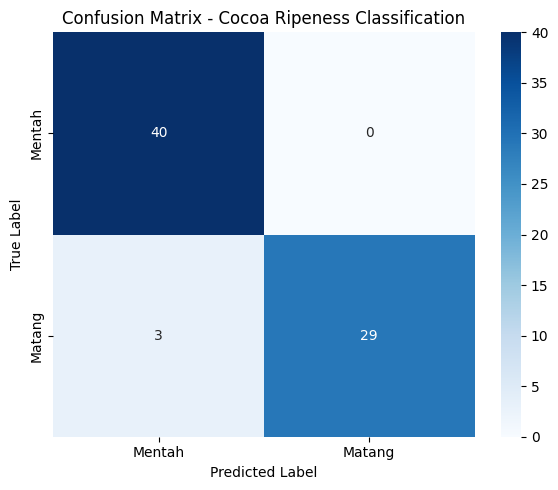


[INFO] Classification Report
              precision    recall  f1-score   support

      Mentah       0.93      1.00      0.96        40
      Matang       1.00      0.91      0.95        32

    accuracy                           0.96        72
   macro avg       0.97      0.95      0.96        72
weighted avg       0.96      0.96      0.96        72



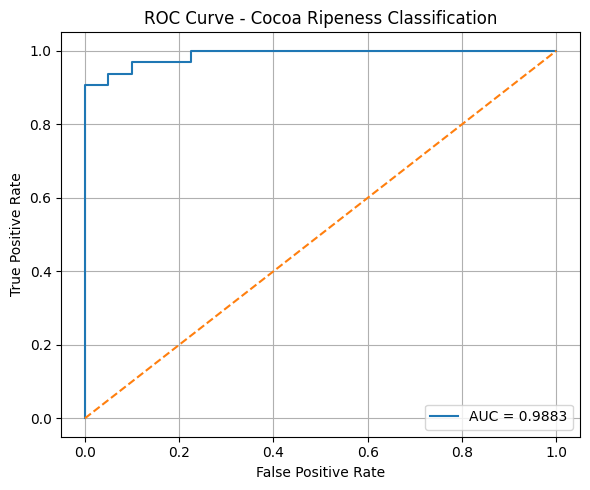

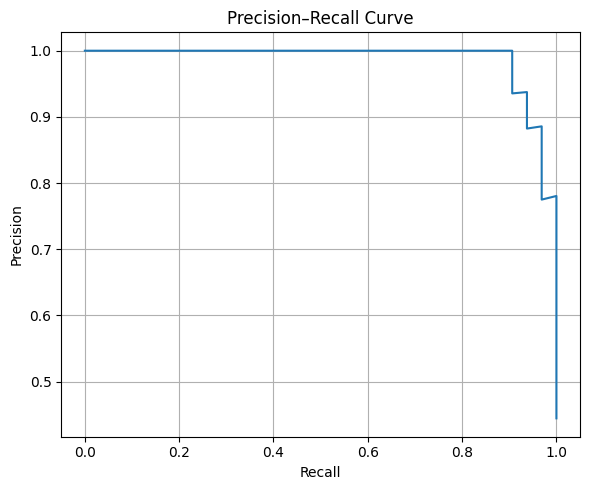

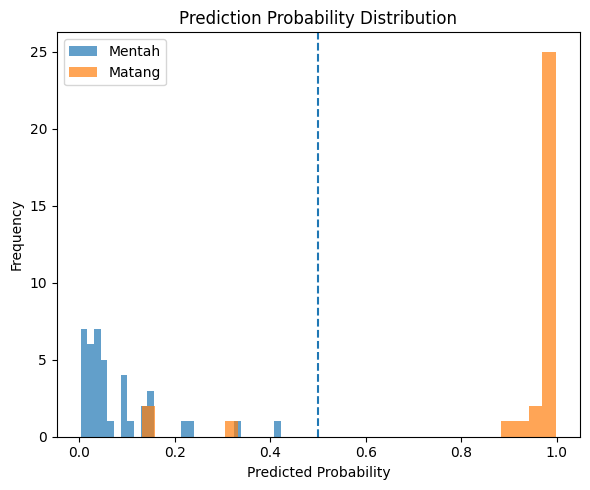

[INFO] Evaluation visualization completed.


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

# =====================================
# 1. AMBIL Y_TRUE & Y_PROB DARI test_ds
# =====================================
print("[INFO] Running inference on test set...")

# The previous code used X_test and y_test numpy arrays,
# not a test_ds TensorFlow dataset.
# We will directly use X_test to get predictions.
y_prob = model.predict(X_test).ravel()
y_true = y_test # y_test already holds the true labels for the test set
y_pred = (y_prob >= 0.5).astype(int)

class_names = ["Mentah", "Matang"]

# =====================================
# 2. CONFUSION MATRIX
# =====================================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Cocoa Ripeness Classification")
plt.tight_layout()
plt.show()

# =====================================
# 3. CLASSIFICATION REPORT
# =====================================
print("\n[INFO] Classification Report")
print(classification_report(y_true, y_pred, target_names=class_names))

# =====================================
# 4. ROC CURVE + AUC
# =====================================
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Cocoa Ripeness Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================
# 5. PRECISION–RECALL CURVE
# =====================================
precision, recall, _ = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================================
# 6. DISTRIBUSI PROBABILITAS PREDIKSI
# =====================================
plt.figure(figsize=(6, 5))
plt.hist(y_prob[y_true == 0], bins=30, alpha=0.7, label="Mentah")
plt.hist(y_prob[y_true == 1], bins=30, alpha=0.7, label="Matang")
plt.axvline(0.5, linestyle="--")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Prediction Probability Distribution")
plt.legend()
plt.tight_layout()
plt.show()

print("[INFO] Evaluation visualization completed.")
